In [8]:
from vqls_prototype import VQLS, VQLSLog
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
import numpy as np

# Variational Quantum Linear Solver

The VQLS is an hybrod variational method to solve linear systems 

$$
A \cdot x = b
$$

where $A$ is a square (symmetric) matrix and $b$ the solution vector. The matrix $A$ should be expressed as a sum of unitary matrices :

$$
A = \sum_n c_n A_n
$$

VQLS soves for $x$ by creating a variational ansatz $|\Psi(\theta)\rangle = V(\theta)|0\rangle$ and a transformation $U$ such as $|b\rangle U|0\rangle$. The solution vector $|x\rangle$ is then obtained by optimizing the parameters $\theta$ to minimize the cost function :

$$
C = \langle \psi(\theta) A^\dagger | (\mathbb{I} - |b\rangle\langle b|) | A \psi(\theta) \rangle
$$

A great tutorial on VQLS can be found on the qiskit [documentation](https://qiskit.org/textbook/ch-paper-implementations/vqls.html), and more details can be found in the original [article](https://arxiv.org/abs/1909.05820)

# Define the system
Let's start by creating a random symmetric 4x4 matrix $A$

In [9]:
nqbit = 2
size = 2**nqbit
A = np.random.rand(size, size)
A = A + A.T

and a random solution vector $b$

In [10]:
b = np.random.rand(size)

We can use the `NumpyLinearSolver` class to obtain the solution of this very simple system

In [11]:
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver

classical_solution = NumPyLinearSolver().solve(A, b / np.linalg.norm(b))

# Define the variational ansatz
Qiskit contains a series of variational circtuits that can be used to define variational ansatz. We will use here the so-called `RealAmplitude` circuit. Since our matrix is 4x4 we will use 2 qbits.

In [ ]:
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3, insert_barriers=False)

## Start the Runtime session
We can start the runtime environement as follow:

In [ ]:
# define the runtime
service = QiskitRuntimeService()
backend = "simulator_statevector"

We can now call the VQLS class within a session to initialize the solver. We use here a statevector backend to obtain very accurate results

In [13]:
with Session(service=service, backend=backend) as session:
    options = Options()
    estimator = Estimator(session=session, options=options)
    log = VQLSLog([], [])
    vqls = VQLS(estimator, ansatz, COBYLA(maxiter=250, disp=True), callback=log.update)

    res = vqls.solve(A, b)

The accuracy of the solution obtained with the VQLS solver can be estimated by comparing the solution vectors obtained with VQLS and the numpy solver

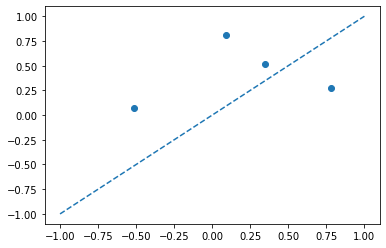

In [17]:
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

ref_solution = classical_solution.state / np.linalg.norm(classical_solution.state)
vqls_solution = np.real(Statevector(res.state).data)


plt.scatter(ref_solution, -vqls_solution)
plt.plot([-1, 1], [-1, 1], "--")

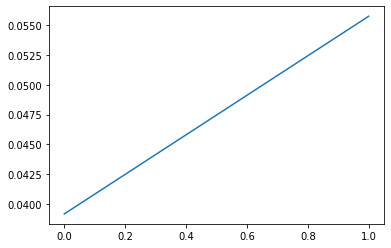

In [18]:
plt.plot(log.values)